### This aims to classify the exosome staus based on a featureset derrived from the peaks.

Import Libraries

In [1]:
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.signal import peak_widths
from scipy.signal import peak_prominences
from scipy.integrate import simps
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [2]:
neo4j_path = 'C:/Users/stang/.Neo4jDesktop/relate-data/dbmss'
neo4j_dbms = 'dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351'

Read the spectral data

In [3]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [4]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8023575 entries, 0 to 8023574
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SpecID      object 
 1   Seq         int64  
 2   WaveNumber  float64
 3   Absorbance  float64
 4   SurID       object 
 5   Status      object 
dtypes: float64(2), int64(1), object(3)
memory usage: 367.3+ MB


Locate and correct the spikes

In [6]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if we has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [7]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return y - z

lam = 10 ** 8
p = 0.05
df['Baseline_Corrected_Absorbance'] = df.groupby('SpecID')['Despiked_Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p))

Remove the noise from the spectra using Savitzky–Golay-filtering

In [8]:
# Set the window size and polynomial order for the Savitzky-Golay filter
window_size = 9
poly_order = 2

# Apply Savitzky-Golay filter to smooth the Absorbance values
df['Smoothed_Absorbance'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

Scale the absorbances of each spectra by the max value.

In [9]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

df['Scaled_Absorbance'] = df.groupby('SpecID')['Smoothed_Absorbance'].transform(lambda x: normalise(x))

Try Min Max Scaling

## 1 Sample Example

In [10]:
sample = df[df['SpecID'] == "210526-3-04"]
print(sample)

              SpecID   Seq  WaveNumber  Absorbance     SurID         Status  \
7981415  210526-3-04     0   200.00000   3094.2837  210526-3  Hyperglycemia   
7981416  210526-3-04     1   200.68336   3109.5640  210526-3  Hyperglycemia   
7981417  210526-3-04     2   201.36674   3041.8801  210526-3  Hyperglycemia   
7981418  210526-3-04     3   202.05011   3033.1189  210526-3  Hyperglycemia   
7981419  210526-3-04     4   202.73349   3061.7734  210526-3  Hyperglycemia   
...              ...   ...         ...         ...       ...            ...   
7984045  210526-3-04  2630  1997.26650   1646.8857  210526-3  Hyperglycemia   
7984046  210526-3-04  2631  1997.94980   1655.2378  210526-3  Hyperglycemia   
7984047  210526-3-04  2632  1998.63330   1652.1541  210526-3  Hyperglycemia   
7984048  210526-3-04  2633  1999.31670   1644.7822  210526-3  Hyperglycemia   
7984049  210526-3-04  2634  2000.00000   1638.7900  210526-3  Hyperglycemia   

         Despiked_Absorbance  Baseline_Corrected_Ab

Find the peaks of each the differently smoothed spectra

In [11]:
#peaks, _ = find_peaks(x=sample['Absorbance'], distance=152, prominence=42, width=6)

raw_peaks, _ = find_peaks(x=sample['Absorbance'])
smooth_peaks, _ = find_peaks(x=sample['Smoothed_Absorbance'])
baseline_peaks, _ = find_peaks(x=sample['Baseline_Corrected_Absorbance'])
despiked_peaks, _ = find_peaks(x=sample['Despiked_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'])
normalised_peaks, _ = find_peaks(x=sample['Scaled_Absorbance'], distance=152, prominence=42/3200, width=6)

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

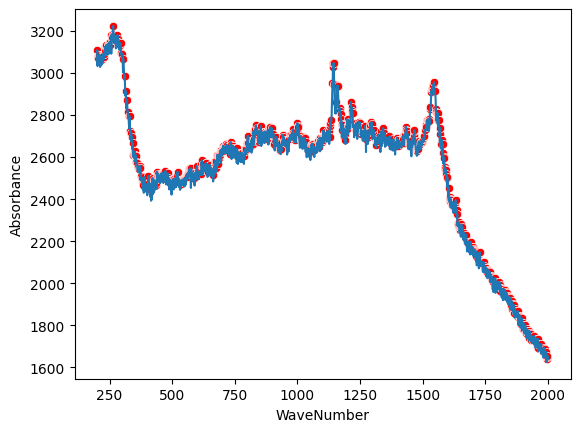

In [12]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[raw_peaks], x="WaveNumber", y="Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Despiked_Absorbance'>

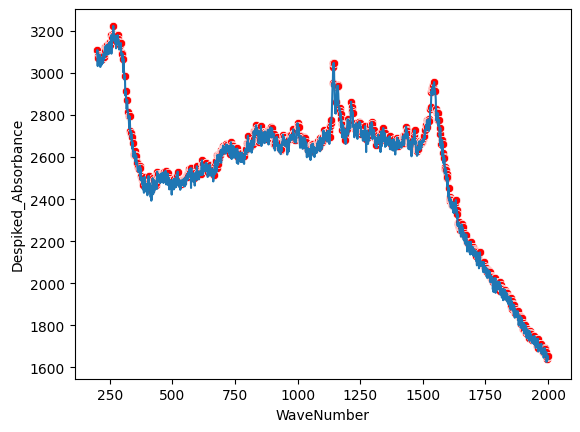

In [13]:
sns.lineplot(x="WaveNumber", y="Despiked_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[despiked_peaks], x="WaveNumber", y="Despiked_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Baseline_Corrected_Absorbance'>

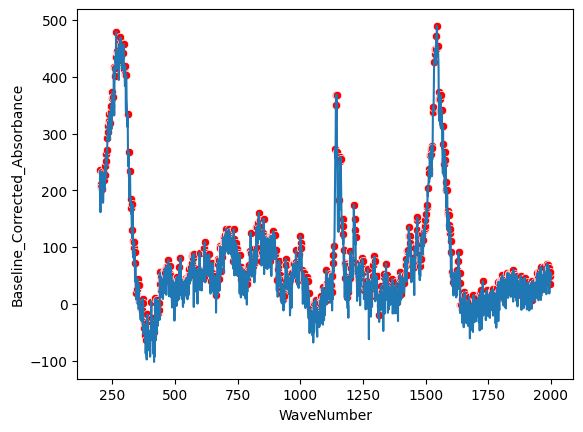

In [14]:
sns.lineplot(x="WaveNumber", y='Baseline_Corrected_Absorbance', data=sample)
sns.scatterplot(data=sample.iloc[baseline_peaks], x="WaveNumber", y="Baseline_Corrected_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Smoothed_Absorbance'>

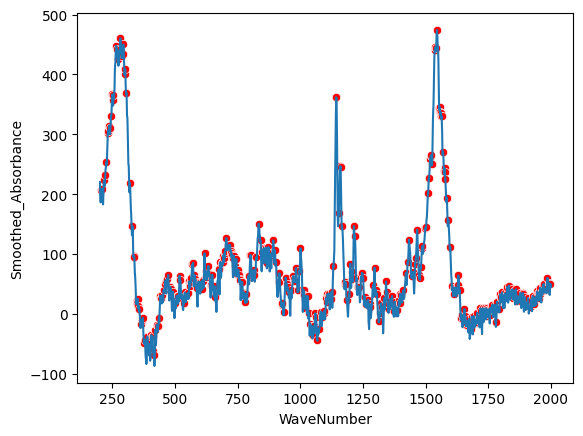

In [15]:
sns.lineplot(x="WaveNumber", y="Smoothed_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[smooth_peaks], x="WaveNumber", y="Smoothed_Absorbance", color="red")

<Axes: xlabel='WaveNumber', ylabel='Scaled_Absorbance'>

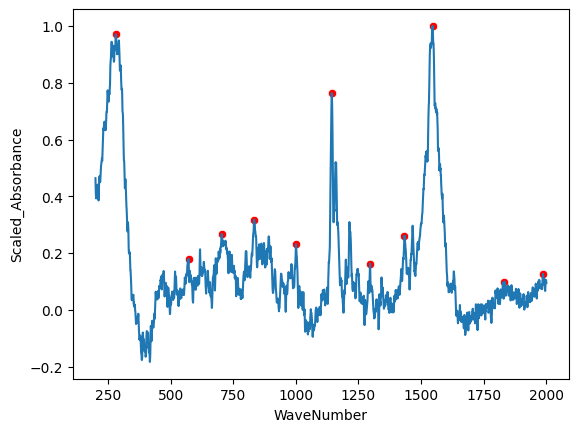

In [16]:
sns.lineplot(x="WaveNumber", y="Scaled_Absorbance", data=sample)
sns.scatterplot(data=sample.iloc[normalised_peaks], x="WaveNumber", y="Scaled_Absorbance", color="red")

The average baseline corrected spectrum of each status

In [17]:
#sns.lineplot(data=df, x='WaveNumber', y='Scaled_Absorbance', hue='Status')

#### Machine Learning

In [18]:
spectra_df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance', 'Smoothed_Absorbance','Despiked_Absorbance'])

In [19]:
spectra_df

,SpecID,Seq,WaveNumber,SurID,Status,Scaled_Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,1.000000
1,201210-1-00,1,200.68336,201210-1,Normal,0.982870
2,201210-1-00,2,201.36674,201210-1,Normal,0.966481
3,201210-1-00,3,202.05011,201210-1,Normal,0.950833
4,201210-1-00,4,202.73349,201210-1,Normal,0.935925
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,0.087327
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,0.090222
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,0.091124
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,0.090032


In [20]:
spectra_df = spectra_df.rename(columns={'Scaled_Absorbance':'Absorbance'})

In [21]:
spectra_df.to_csv("../../data/scaled_and_noise_removal.csv")

## Graph

In [22]:
spectra_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,1.000000
1,201210-1-00,1,200.68336,201210-1,Normal,0.982870
2,201210-1-00,2,201.36674,201210-1,Normal,0.966481
3,201210-1-00,3,202.05011,201210-1,Normal,0.950833
4,201210-1-00,4,202.73349,201210-1,Normal,0.935925
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,0.087327
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,0.090222
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,0.091124
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,0.090032


In [23]:
peaks = []
widths = []
prominences = []
areas = []

df = spectra_df.copy()

# Find the index and width of each peak
for _, group in df.groupby('SpecID'):

    peak_index, _ = find_peaks(x=group['Absorbance'], distance=50, prominence=42/3200, width=6)
    #peak_index, _ = find_peaks(x=group['Absorbance'])
    #peak_index, _ = find_peaks(x=group['Absorbance'], prominence=75)

    # Calculate the widths of each peak
    widths += list(peak_widths(group['Absorbance'], peaks=peak_index, rel_height=0.5)[0])

    # Calculate prominence of each peak
    prominences += list(peak_prominences(group['Absorbance'], peaks=peak_index)[0])

    # Find the index of the peak within the full dataframe
    peaks += list(group.iloc[peak_index].index.values)

peaks_df = df.iloc[peaks]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

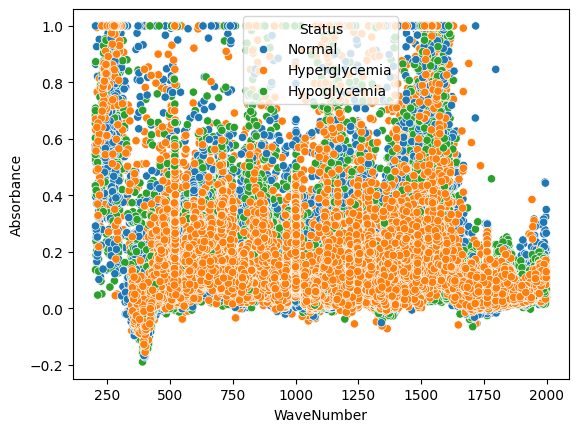

In [24]:
sns.scatterplot(data=peaks_df, x="WaveNumber", y="Absorbance", hue="Status")

In [25]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [26]:
peak_df = peaks_df

In [27]:
peak_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
76,201210-1-00,76,251.93622,201210-1,Normal,0.852790
257,201210-1-00,257,375.62643,201210-1,Normal,0.018559
326,201210-1-00,326,422.77905,201210-1,Normal,-0.032742
386,201210-1-00,386,463.78131,201210-1,Normal,0.088690
487,201210-1-00,487,532.80182,201210-1,Normal,0.100782
...,...,...,...,...,...,...
8009841,210526-3-49,2076,1618.67880,210526-3,Hyperglycemia,0.147085
8009935,210526-3-49,2170,1682.91580,210526-3,Hyperglycemia,0.074500
8010001,210526-3-49,2236,1728.01820,210526-3,Hyperglycemia,0.058155
8010192,210526-3-49,2427,1858.54210,210526-3,Hyperglycemia,0.111614


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

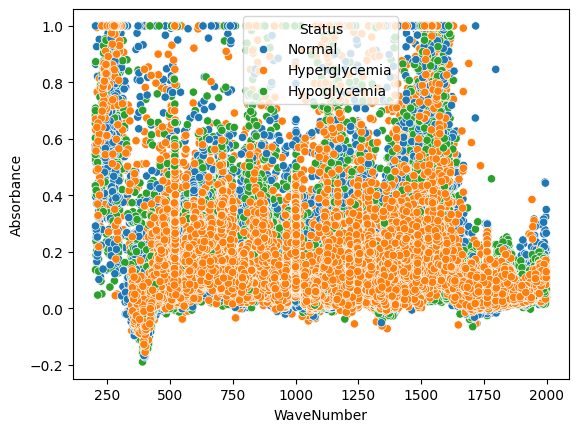

In [28]:
sns.scatterplot(data=spectra_df.iloc[peaks], x="WaveNumber", y="Absorbance", hue="Status")

In [29]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 0.025

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

C:\Users\stang\AppData\Local\Temp\ipykernel_24128\1009779721.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [30]:
peak_df['GridSlot'].nunique()

1189

In [31]:
peak_df['Node_ID'] = peak_df.index

C:\Users\stang\AppData\Local\Temp\ipykernel_24128\412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [32]:
peak_df = peak_df.drop(columns=['Seq', 'SurID']) # Dropping irrelevant columns

Here, the Wavenumber values are scaled so as to not have a bias towards one axis when calculating distance between peaks

In [33]:
peak_df['OriginalWaveNumber'] = peak_df['WaveNumber']

In [34]:
peak_df['WaveNumber'] = peak_df['WaveNumber']/max(peak_df['WaveNumber'])

In [35]:
peak_df

,SpecID,WaveNumber,Status,Absorbance,GridSlot,Node_ID,OriginalWaveNumber
76,201210-1-00,0.126141,Normal,0.852790,"(5, 34)",76,251.93622
257,201210-1-00,0.188070,Normal,0.018559,"(7, 0)",257,375.62643
326,201210-1-00,0.211679,Normal,-0.032742,"(8, -1)",326,422.77905
386,201210-1-00,0.232208,Normal,0.088690,"(9, 3)",386,463.78131
487,201210-1-00,0.266766,Normal,0.100782,"(10, 4)",487,532.80182
...,...,...,...,...,...,...,...
8009841,210526-3-49,0.810447,Hyperglycemia,0.147085,"(32, 5)",8009841,1618.67880
8009935,210526-3-49,0.842610,Hyperglycemia,0.074500,"(33, 2)",8009935,1682.91580
8010001,210526-3-49,0.865192,Hyperglycemia,0.058155,"(34, 2)",8010001,1728.01820
8010192,210526-3-49,0.930543,Hyperglycemia,0.111614,"(37, 4)",8010192,1858.54210


Because our graph structure depends on linking every peak in the same sample together, we cannot just randomly split the rows. We have to first randomly split the samples 80:20, and then split our peak dataframe. We do this to keep all peaks of the same sample in the same dataframe while retaining the non-uniform structure.

In [36]:
unique_values = peak_df['SpecID'].unique().tolist()

In [37]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(unique_values, test_size=0.2, random_state=1234)

In [38]:
train_df = peak_df[peak_df['SpecID'].isin(train)]
test_df = peak_df[peak_df['SpecID'].isin(test)]

In [39]:
train_df

,SpecID,WaveNumber,Status,Absorbance,GridSlot,Node_ID,OriginalWaveNumber
76,201210-1-00,0.126141,Normal,0.852790,"(5, 34)",76,251.93622
257,201210-1-00,0.188070,Normal,0.018559,"(7, 0)",257,375.62643
326,201210-1-00,0.211679,Normal,-0.032742,"(8, -1)",326,422.77905
386,201210-1-00,0.232208,Normal,0.088690,"(9, 3)",386,463.78131
487,201210-1-00,0.266766,Normal,0.100782,"(10, 4)",487,532.80182
...,...,...,...,...,...,...,...
8009841,210526-3-49,0.810447,Hyperglycemia,0.147085,"(32, 5)",8009841,1618.67880
8009935,210526-3-49,0.842610,Hyperglycemia,0.074500,"(33, 2)",8009935,1682.91580
8010001,210526-3-49,0.865192,Hyperglycemia,0.058155,"(34, 2)",8010001,1728.01820
8010192,210526-3-49,0.930543,Hyperglycemia,0.111614,"(37, 4)",8010192,1858.54210


In [40]:
def graph(train_df):
    same_sample = pd.merge(train_df, train_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))

    same_grid_slot = pd.merge(train_df, train_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))

    train_graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

    #train_graph_df = train_graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])
    train_graph_df = train_graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'OriginalWaveNumber'])

    train_graph_df = train_graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})
    train_graph_df['LINK:TYPE'] = 'LINK'

    train_graph_df = train_graph_df[train_graph_df[':START_ID'] != train_graph_df[':END_ID']]

    wave = train_df['WaveNumber']
    absorb = train_df['Absorbance']

    src_indices = train_graph_df[':START_ID'].values
    dst_indices = train_graph_df[':END_ID'].values

    src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
    dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

    #Use euclidiean distance numpy function to efficiently calculate distances
    distances = np.linalg.norm(src_coords - dst_coords, axis=1)

    dist = distances.tolist()

    train_graph_df['DIST'] = dist

    train_graph_df['DIST'] = dist

    train_graph_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

    train_graph_df.to_csv(f"{neo4j_path}/{neo4j_dbms}/import/relationships.csv", index=False)

    train_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

    #train_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)
    train_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Node_ID':'Node_ID:ID', 'OriginalWaveNumber':'OriginalWaveNumber:float'}, inplace=True)


    train_df.to_csv(f"{neo4j_path}/{neo4j_dbms}/import/nodes.csv", index=False)

    return [train_df, train_graph_df]

In [41]:
train = graph(train_df)

C:\Users\stang\AppData\Local\Temp\ipykernel_24128\1753209114.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)
C:\Users\stang\AppData\Local\Temp\ipykernel_24128\1753209114.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Node_ID':'Node_ID:ID', 'OriginalWaveNumber':'OriginalWaveNumber:float'}, inplace=True)


In [47]:
train[1]

,:START_ID,:END_ID,LINK:TYPE,DIST:float
1,76,257,LINK,0.836527
2,76,326,LINK,0.889654
3,76,386,LINK,0.771427
4,76,487,LINK,0.765044
5,76,613,LINK,0.495981
...,...,...,...,...
12587894,6888419,7818562,LINK,0.011083
12587895,7157242,6888419,LINK,0.019077
12587897,7157242,7818562,LINK,0.022666
12587898,7818562,6888419,LINK,0.011083


In [42]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [43]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_path}/{neo4j_dbms}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_path}/{neo4j_dbms}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.12.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 14.70GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 12.49GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'WaveNumber' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv
  Property type of 'Absorbance' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\re

Run and connect to the Neo4j Database

In [48]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#password = os.environ['NEO4J_Password']           # Neo4J password
password = '26622002'

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [49]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Define the graph algorithms.

In [50]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [51]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [52]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [53]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [54]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [55]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [56]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [57]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [58]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'DIST',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [59]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    #label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    #louvain_results = session.execute_read(run_louvain_algorithm)

In [60]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'id', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'id', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'id', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'id', 'ArticleRank'])
#label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'id', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'id', 'Leiden'])
#louvain_df = pd.DataFrame(louvain_results, columns=['name', 'id', 'Louvain'])

In [63]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df]:
    merged_df = pd.merge(merged_df, df, on=['id', 'name'], how='left')

In [89]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden
0,210114-1-36,355802,3.831757,102.434595,0.019938,0.176965,1196
1,210414-1-17,5422904,3.796557,101.709661,0.019787,0.176766,354
2,210114-1-35,353177,3.708633,98.300313,0.019128,0.175907,1195
3,210303-1-38,2205573,3.676435,91.276208,0.017899,0.174041,109
4,210120-2-22,714166,3.645104,93.046787,0.018163,0.174512,617
...,...,...,...,...,...,...,...
52183,210504-2-08,6386143,0.460332,6.888096,0.001362,0.151822,98
52184,210331-1-47,4338749,0.456329,6.838277,0.001350,0.151810,98
52185,210504-2-02,6370334,0.449523,6.785355,0.001341,0.151795,98
52186,210324-2-00,3818844,0.444719,6.721603,0.001321,0.151780,98


In [65]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'id', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,76,0.113277,0.295899,-0.259409,-0.016944,-0.066594,0.188546,-0.163382,-0.165674,...,0.121437,-0.150056,0.453799,0.191553,-0.105432,0.013395,-0.261888,-0.083051,0.211744,0.076862
1,201210-1-00,257,0.125181,0.309766,-0.267688,-0.010263,-0.049953,0.203363,-0.178148,-0.156914,...,0.128552,-0.128242,0.455102,0.169775,-0.092068,0.009134,-0.249505,-0.100983,0.214439,0.060560
2,201210-1-00,326,0.114340,0.292860,-0.253893,-0.011437,-0.063669,0.200747,-0.168151,-0.170304,...,0.124766,-0.152542,0.462615,0.184916,-0.118095,0.009057,-0.256292,-0.088119,0.199069,0.076286
3,201210-1-00,386,0.113650,0.290094,-0.253402,-0.022244,-0.058741,0.204902,-0.171351,-0.175571,...,0.119361,-0.149628,0.466353,0.183723,-0.118549,0.008014,-0.251882,-0.081418,0.202742,0.075143
4,201210-1-00,487,0.125114,0.279534,-0.248368,-0.007222,-0.076708,0.198264,-0.161653,-0.175380,...,0.127044,-0.152679,0.471404,0.187344,-0.119700,0.011284,-0.250390,-0.089388,0.204978,0.080778


In [66]:
fastRP_df

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,76,0.113277,0.295899,-0.259409,-0.016944,-0.066594,0.188546,-0.163382,-0.165674,...,0.121437,-0.150056,0.453799,0.191553,-0.105432,0.013395,-0.261888,-0.083051,0.211744,0.076862
1,201210-1-00,257,0.125181,0.309766,-0.267688,-0.010263,-0.049953,0.203363,-0.178148,-0.156914,...,0.128552,-0.128242,0.455102,0.169775,-0.092068,0.009134,-0.249505,-0.100983,0.214439,0.060560
2,201210-1-00,326,0.114340,0.292860,-0.253893,-0.011437,-0.063669,0.200747,-0.168151,-0.170304,...,0.124766,-0.152542,0.462615,0.184916,-0.118095,0.009057,-0.256292,-0.088119,0.199069,0.076286
3,201210-1-00,386,0.113650,0.290094,-0.253402,-0.022244,-0.058741,0.204902,-0.171351,-0.175571,...,0.119361,-0.149628,0.466353,0.183723,-0.118549,0.008014,-0.251882,-0.081418,0.202742,0.075143
4,201210-1-00,487,0.125114,0.279534,-0.248368,-0.007222,-0.076708,0.198264,-0.161653,-0.175380,...,0.127044,-0.152679,0.471404,0.187344,-0.119700,0.011284,-0.250390,-0.089388,0.204978,0.080778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52183,210518-1-34,7229418,0.107154,0.112204,0.110508,0.126525,-0.050650,-0.267578,-0.275461,-0.051004,...,0.177273,-0.201138,0.093515,-0.136137,-0.486159,-0.097771,-0.024378,0.024761,-0.061628,0.051221
52184,210518-1-34,7229520,0.109068,0.104088,0.105450,0.124994,-0.053075,-0.267740,-0.276524,-0.060870,...,0.179252,-0.198869,0.088144,-0.132496,-0.480935,-0.096986,-0.012521,0.023648,-0.066185,0.059574
52185,210518-1-34,7229577,0.108258,0.102343,0.113021,0.127272,-0.062583,-0.271750,-0.276082,-0.051284,...,0.185970,-0.191915,0.095687,-0.118756,-0.477974,-0.096304,-0.012709,0.001570,-0.079746,0.046265
52186,210518-1-34,7229769,0.118712,0.101924,0.101811,0.123630,-0.057139,-0.269245,-0.275036,-0.056308,...,0.179414,-0.196270,0.095023,-0.138901,-0.481703,-0.095105,-0.015662,0.020636,-0.066749,0.057706


In [68]:
status_df = pd.read_csv(f"{neo4j_path}/{neo4j_dbms}/import/nodes.csv")

In [93]:
df['id'] = df['id'].astype(int)

In [70]:
fastRP_df['id'] = fastRP_df['id'].astype(int)

In [100]:
graph_df = pd.merge(df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [143]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
fast_graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [101]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
graph_df.drop(columns=['SpecID_y', 'WaveNumber:float'], inplace=True)
graph_df.rename(columns={'SpecID_x':'SpecID', 'OriginalWaveNumber:float':'WaveNumber'}, inplace=True)
graph_df.drop(columns=['Absorbance:float', 'GridSlot'], inplace=True)

In [144]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
fast_graph_df.drop(columns=['SpecID_y', 'WaveNumber:float'], inplace=True)
fast_graph_df.rename(columns={'SpecID_x':'SpecID', 'OriginalWaveNumber:float':'WaveNumber'}, inplace=True)
fast_graph_df.drop(columns=['Absorbance:float', 'GridSlot', 'WaveNumber'], inplace=True)

In [102]:
graph_df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Status,WaveNumber
0,210114-1-36,355802,3.831757,102.434595,0.019938,0.176965,1196,Normal,252.61958
1,210414-1-17,5422904,3.796557,101.709661,0.019787,0.176766,354,Normal,250.56947
2,210114-1-35,353177,3.708633,98.300313,0.019128,0.175907,1195,Normal,259.45331
3,210303-1-38,2205573,3.676435,91.276208,0.017899,0.174041,109,Normal,253.30296
4,210120-2-22,714166,3.645104,93.046787,0.018163,0.174512,617,Hyperglycemia,255.35307
...,...,...,...,...,...,...,...,...,...
52183,210504-2-08,6386143,0.460332,6.888096,0.001362,0.151822,98,Hypoglycemia,1251.02500
52184,210331-1-47,4338749,0.456329,6.838277,0.001350,0.151810,98,Hypoglycemia,1251.70840
52185,210504-2-02,6370334,0.449523,6.785355,0.001341,0.151795,98,Hypoglycemia,1251.70840
52186,210324-2-00,3818844,0.444719,6.721603,0.001321,0.151780,98,Normal,698.17767


In [103]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
graph_df['Bin'] = graph_df['WaveNumber'].apply(lambda x: calculate_bin_interval(x, bin_size))

In [104]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
#peak_bins = graph_df.pivot_table(index='SpecID', columns='Bin', values=['PageRank', 'DegreeCentrality', 'EigenvectorCentrality', 'ArticleRank', 'Leiden', 'Louvain'], aggfunc='mean')
peak_bins = graph_df.pivot_table(index='SpecID', columns='Bin', values=['PageRank', 'DegreeCentrality', 'EigenvectorCentrality', 'ArticleRank', 'Leiden'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = graph_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

C:\Users\stang\AppData\Local\Temp\ipykernel_24128\205535428.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [105]:
peak_bins

,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,ArticleRank_1225-1250,...,PageRank_775-800,PageRank_800-825,PageRank_825-850,PageRank_850-875,PageRank_875-900,PageRank_900-925,PageRank_925-950,PageRank_950-975,PageRank_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.153828,False,0.153561,False,False,0.154679,False,0.155708,False,0.154736,...,False,0.96662,False,0.795786,False,0.701084,False,False,False,Normal
201210-1-01,0.153978,False,0.153745,False,False,0.154453,False,0.154937,False,0.154384,...,False,False,False,0.778403,0.92237,False,0.688038,False,False,Normal
201210-1-02,0.154018,0.154651,False,0.155039,False,0.15409,False,False,False,0.154772,...,False,False,False,False,False,1.665716,False,False,False,Normal
201210-1-03,False,False,False,False,False,False,0.152688,False,False,False,...,False,False,False,False,False,0.528835,False,0.681982,False,Normal
201210-1-04,0.154587,False,0.154699,False,False,False,False,0.154524,False,False,...,0.8676,False,1.012829,0.845254,False,0.885928,False,False,False,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-44,0.154116,False,False,False,0.154782,0.155458,False,False,0.153979,False,...,False,False,False,0.750666,False,False,False,0.822226,False,Hyperglycemia
210526-3-45,0.154427,False,False,False,False,0.153866,False,False,0.153943,False,...,0.917841,False,False,0.810119,False,False,False,False,False,Hyperglycemia
210526-3-46,0.154567,False,False,0.157494,False,0.154617,0.155666,False,False,0.154519,...,False,False,0.759767,False,0.748642,0.77283,False,False,False,Hyperglycemia


In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

RandomForestClassifier Cross-Validation Accuracy: 0.7188 +/- 0.0251
ExtraTreesClassifier Cross-Validation Accuracy: 0.6749 +/- 0.0343


In [107]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [109]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [110]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(25)

    return top_10_features

In [111]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.7008196721311475


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.73      0.65      0.69       153
 Hypoglycemia       0.68      0.79      0.73       163
       Normal       0.70      0.66      0.68       172

     accuracy                           0.70       488
    macro avg       0.70      0.70      0.70       488
 weighted avg       0.70      0.70      0.70       488


Confusion Matrix:
[[100  26  27]
 [ 13 128  22]
 [ 24  34 114]]


In [112]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.6413934426229508


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.65      0.58      0.62       153
 Hypoglycemia       0.61      0.72      0.66       163
       Normal       0.67      0.62      0.64       172

     accuracy                           0.64       488
    macro avg       0.64      0.64      0.64       488
 weighted avg       0.64      0.64      0.64       488


Confusion Matrix:
[[ 89  41  23]
 [ 16 118  29]
 [ 31  35 106]]


In [120]:
fast_graph_df

,SpecID_x,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_124,embedding_125,embedding_126,embedding_127,SpecID_y,WaveNumber:float,Status:LABEL,Absorbance:float,GridSlot,OriginalWaveNumber:float
0,201210-1-00,0.113277,0.295899,-0.259409,-0.016944,-0.066594,0.188546,-0.163382,-0.165674,-0.081923,...,-0.261888,-0.083051,0.211744,0.076862,201210-1-00,0.126141,Normal,0.852790,"(5, 34)",251.93622
1,201210-1-00,0.125181,0.309766,-0.267688,-0.010263,-0.049953,0.203363,-0.178148,-0.156914,-0.075969,...,-0.249505,-0.100983,0.214439,0.060560,201210-1-00,0.188070,Normal,0.018559,"(7, 0)",375.62643
2,201210-1-00,0.114340,0.292860,-0.253893,-0.011437,-0.063669,0.200747,-0.168151,-0.170304,-0.081127,...,-0.256292,-0.088119,0.199069,0.076286,201210-1-00,0.211679,Normal,-0.032742,"(8, -1)",422.77905
3,201210-1-00,0.113650,0.290094,-0.253402,-0.022244,-0.058741,0.204902,-0.171351,-0.175571,-0.076849,...,-0.251882,-0.081418,0.202742,0.075143,201210-1-00,0.232208,Normal,0.088690,"(9, 3)",463.78131
4,201210-1-00,0.125114,0.279534,-0.248368,-0.007222,-0.076708,0.198264,-0.161653,-0.175380,-0.076167,...,-0.250390,-0.089388,0.204978,0.080778,201210-1-00,0.266766,Normal,0.100782,"(10, 4)",532.80182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52183,210518-1-34,0.107154,0.112204,0.110508,0.126525,-0.050650,-0.267578,-0.275461,-0.051004,0.070894,...,-0.024378,0.024761,-0.061628,0.051221,210518-1-34,0.652030,Hyperglycemia,0.209422,"(26, 8)",1302.27800
52184,210518-1-34,0.109068,0.104088,0.105450,0.124994,-0.053075,-0.267740,-0.276524,-0.060870,0.068116,...,-0.012521,0.023648,-0.066185,0.059574,210518-1-34,0.686930,Hyperglycemia,0.258237,"(27, 10)",1371.98180
52185,210518-1-34,0.108258,0.102343,0.113021,0.127272,-0.062583,-0.271750,-0.276082,-0.051284,0.090516,...,-0.012709,0.001570,-0.079746,0.046265,210518-1-34,0.706433,Hyperglycemia,0.228793,"(28, 9)",1410.93400
52186,210518-1-34,0.118712,0.101924,0.101811,0.123630,-0.057139,-0.269245,-0.275036,-0.056308,0.072484,...,-0.015662,0.020636,-0.066749,0.057706,210518-1-34,0.772126,Hyperglycemia,0.289133,"(30, 11)",1542.14120


In [123]:
fast_graph_df.drop(columns=['id'], inplace=True)
fast_graph_df = fast_graph_df.groupby(['SpecID', 'Status']).max().reset_index()

In [145]:
fast_graph_df

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,Status
0,201210-1-00,76,0.113277,0.295899,-0.259409,-0.016944,-0.066594,0.188546,-0.163382,-0.165674,...,-0.150056,0.453799,0.191553,-0.105432,0.013395,-0.261888,-0.083051,0.211744,0.076862,Normal
1,201210-1-00,257,0.125181,0.309766,-0.267688,-0.010263,-0.049953,0.203363,-0.178148,-0.156914,...,-0.128242,0.455102,0.169775,-0.092068,0.009134,-0.249505,-0.100983,0.214439,0.060560,Normal
2,201210-1-00,326,0.114340,0.292860,-0.253893,-0.011437,-0.063669,0.200747,-0.168151,-0.170304,...,-0.152542,0.462615,0.184916,-0.118095,0.009057,-0.256292,-0.088119,0.199069,0.076286,Normal
3,201210-1-00,386,0.113650,0.290094,-0.253402,-0.022244,-0.058741,0.204902,-0.171351,-0.175571,...,-0.149628,0.466353,0.183723,-0.118549,0.008014,-0.251882,-0.081418,0.202742,0.075143,Normal
4,201210-1-00,487,0.125114,0.279534,-0.248368,-0.007222,-0.076708,0.198264,-0.161653,-0.175380,...,-0.152679,0.471404,0.187344,-0.119700,0.011284,-0.250390,-0.089388,0.204978,0.080778,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52183,210518-1-34,7229418,0.107154,0.112204,0.110508,0.126525,-0.050650,-0.267578,-0.275461,-0.051004,...,-0.201138,0.093515,-0.136137,-0.486159,-0.097771,-0.024378,0.024761,-0.061628,0.051221,Hyperglycemia
52184,210518-1-34,7229520,0.109068,0.104088,0.105450,0.124994,-0.053075,-0.267740,-0.276524,-0.060870,...,-0.198869,0.088144,-0.132496,-0.480935,-0.096986,-0.012521,0.023648,-0.066185,0.059574,Hyperglycemia
52185,210518-1-34,7229577,0.108258,0.102343,0.113021,0.127272,-0.062583,-0.271750,-0.276082,-0.051284,...,-0.191915,0.095687,-0.118756,-0.477974,-0.096304,-0.012709,0.001570,-0.079746,0.046265,Hyperglycemia
52186,210518-1-34,7229769,0.118712,0.101924,0.101811,0.123630,-0.057139,-0.269245,-0.275036,-0.056308,...,-0.196270,0.095023,-0.138901,-0.481703,-0.095105,-0.015662,0.020636,-0.066749,0.057706,Hyperglycemia


In [125]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)


Random Forest Accuracy: 0.3668032786885246
Extra Trees Accuracy: 0.36270491803278687


In [127]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.3668032786885246


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.40      0.11      0.17       150
 Hypoglycemia       0.33      0.47      0.39       171
       Normal       0.40      0.50      0.44       167

     accuracy                           0.37       488
    macro avg       0.38      0.36      0.33       488
 weighted avg       0.38      0.37      0.34       488


Confusion Matrix:
[[16 83 51]
 [16 80 75]
 [ 8 76 83]]


In [128]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.36270491803278687


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.33      0.12      0.18       150
 Hypoglycemia       0.39      0.50      0.44       171
       Normal       0.34      0.44      0.38       167

     accuracy                           0.36       488
    macro avg       0.36      0.35      0.33       488
 weighted avg       0.36      0.36      0.34       488


Confusion Matrix:
[[18 62 70]
 [13 86 72]
 [23 71 73]]


In [129]:
get_feature_importances(rf_model, X)

,Feature,Importance
21,embedding_21,0.009937
55,embedding_55,0.009614
126,embedding_126,0.009380
6,embedding_6,0.009211
100,embedding_100,0.009178
37,embedding_37,0.009153
125,embedding_125,0.009111
78,embedding_78,0.008914
35,embedding_35,0.008827
44,embedding_44,0.008706


In [130]:
get_feature_importances(et_model, X)

,Feature,Importance
37,embedding_37,0.008738
24,embedding_24,0.008583
64,embedding_64,0.008482
90,embedding_90,0.008459
34,embedding_34,0.008451
28,embedding_28,0.008395
56,embedding_56,0.008385
78,embedding_78,0.008338
11,embedding_11,0.008328
55,embedding_55,0.008325


In [142]:
fast_graph_df

,SpecID,Status,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,Normal,0.147708,0.309766,-0.248368,-0.007222,-0.048450,0.223101,-0.147266,-0.151009,...,0.143806,-0.128242,0.471950,0.218483,-0.064664,0.052799,-0.248173,-0.065974,0.214439,0.093154
1,201210-1-01,Normal,0.033423,-0.073093,0.060619,-0.046344,-0.009289,0.055725,-0.122472,0.273836,...,0.286483,-0.011349,-0.330357,0.272057,0.064138,-0.000165,-0.075850,-0.110234,-0.209577,-0.014355
2,201210-1-02,Normal,-0.157481,-0.099214,0.296483,0.060042,-0.000648,-0.001315,0.185772,0.185268,...,-0.170584,0.263656,-0.226273,0.006428,0.067373,-0.156213,0.103215,-0.002269,-0.038293,0.341382
3,201210-1-03,Normal,0.126716,-0.221670,-0.035320,-0.047952,0.113820,-0.168122,-0.258562,-0.058872,...,0.176153,0.068539,0.013130,0.040540,0.288667,-0.275623,0.072705,-0.100655,0.109836,0.000703
4,201210-1-04,Normal,-0.185422,-0.222321,-0.225234,0.019327,-0.073587,-0.074808,-0.123938,-0.591094,...,0.204695,0.186495,0.200927,0.011119,0.374674,-0.154584,0.088294,-0.199132,0.095502,0.028341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2431,210526-3-44,Hyperglycemia,-0.023010,-0.169693,0.013522,0.150107,-0.011697,0.110275,0.335220,0.060474,...,0.005120,0.215236,-0.007554,0.177463,0.132915,-0.036112,-0.265186,-0.150371,-0.055532,0.236569
2432,210526-3-45,Hyperglycemia,0.104036,0.138804,0.444155,0.172367,0.051530,0.154726,0.130138,0.160789,...,-0.221853,0.007315,0.323742,0.101191,0.156794,-0.078187,0.131218,0.071585,0.255225,-0.198327
2433,210526-3-46,Hyperglycemia,0.003858,-0.015524,0.273062,0.233494,0.208552,0.011952,-0.308985,0.028687,...,-0.259563,0.108791,-0.119051,-0.375153,-0.166002,0.076491,0.275770,0.004485,-0.050289,-0.151447
2434,210526-3-48,Hyperglycemia,-0.055198,-0.172622,0.075575,0.146203,-0.050936,0.253643,0.024781,0.162791,...,-0.109400,0.163950,-0.268663,0.069494,0.338605,0.205147,-0.202773,-0.272903,0.092461,-0.235264


In [137]:
unique_values = fast_graph_df['SpecID'].unique().tolist()

In [138]:
train, test = train_test_split(unique_values, test_size=0.2, random_state=1234)

In [139]:
train_df = fast_graph_df[fast_graph_df['SpecID'].isin(train)]
test_df = fast_graph_df[fast_graph_df['SpecID'].isin(test)]

In [140]:
value_counts = test_df['Status'].value_counts()

print(value_counts)

Status
Normal           172
Hypoglycemia     163
Hyperglycemia    153
Name: count, dtype: int64


In [141]:
# Drop the SpecID column
X_train = train_df.drop(columns=['SpecID', 'Status', 'id'])

# Target variable
y_train= train_df['Status']

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

KeyError: "['id'] not found in axis"

In [ ]:
def ensemble_pred(model, X_test):
    prediction = model.predict(X_test)
    return prediction


In [ ]:
X_test = test_df.drop(columns=['SpecID', 'Status', 'id'])
y_test = test_df['Status']

In [ ]:
result = ensemble_pred(et_model, X_test)

In [ ]:
accuracy = accuracy_score(y_test, result)

In [ ]:
accuracy

0.3433113609926328

In [ ]:
result_df = result.join(y_test)

In [ ]:
result_df

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127,predictions,SpecID,id,Status
187,0.074743,-0.415970,0.613765,0.201123,0.133562,-0.116933,0.028692,0.173704,0.211737,0.150171,...,-0.010628,0.047397,0.000789,0.114177,-0.126641,0.086094,Hypoglycemia,210421-1-21,5040987,Normal
188,0.076432,-0.396298,0.595790,0.222759,0.138462,-0.117403,0.002030,0.190719,0.212822,0.170548,...,-0.020865,0.050474,0.023122,0.085597,-0.134768,0.110571,Hypoglycemia,210421-1-21,5041132,Normal
189,0.055294,-0.402428,0.595596,0.226997,0.135008,-0.124002,0.006198,0.169250,0.211475,0.173995,...,-0.021711,0.040263,0.037192,0.109837,-0.129213,0.118357,Hypoglycemia,210421-1-21,5041203,Normal
190,0.074283,-0.398744,0.596125,0.215075,0.152756,-0.124699,0.001297,0.196083,0.200662,0.164035,...,-0.018757,0.042078,0.028636,0.097731,-0.130284,0.107098,Hypoglycemia,210421-1-21,5041296,Normal
191,0.100249,-0.390776,0.581041,0.232668,0.130775,-0.092609,-0.049520,0.194864,0.224587,0.157190,...,-0.030285,0.064996,0.093184,0.048962,-0.170189,0.085308,Hypoglycemia,210421-1-21,5041356,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65161,0.100057,0.040536,-0.255624,0.010198,-0.221306,-0.424600,-0.172966,0.014593,-0.000857,-0.292851,...,-0.161723,0.213540,0.258775,-0.075005,0.016291,0.066482,Normal,210421-1-09,5135055,Normal
65162,0.105455,0.042327,-0.253205,0.004443,-0.210196,-0.427927,-0.179131,0.008624,-0.001742,-0.297020,...,-0.162230,0.216889,0.259210,-0.083966,0.011858,0.077052,Normal,210421-1-09,5135269,Normal
65163,0.107495,0.036649,-0.251965,0.003877,-0.213531,-0.431670,-0.180962,0.011332,0.000449,-0.298128,...,-0.164517,0.212953,0.260288,-0.081891,0.013264,0.069571,Normal,210421-1-09,5135355,Normal
65164,0.104413,0.041694,-0.252355,0.005855,-0.213241,-0.431924,-0.177525,0.012054,-0.001264,-0.298398,...,-0.161550,0.217441,0.262780,-0.081620,0.012481,0.072131,Normal,210421-1-09,5135421,Normal


In [ ]:
mode_df = result_df.groupby("SpecID")[["predictions", "Status"]].agg(lambda x: x.mode().iloc[0])


In [ ]:
mode_df

,predictions,Status
SpecID,,
201210-1-01,Hypoglycemia,Normal
201210-1-02,Normal,Normal
201210-1-12,Normal,Normal
201210-1-22,Normal,Normal
201210-1-34,Normal,Normal
...,...,...
210526-3-27,Hypoglycemia,Hyperglycemia
210526-3-34,Hypoglycemia,Hyperglycemia
210526-3-40,Normal,Hyperglycemia


In [ ]:
# Calculate the number of matching predictions and statuses
matching_values = (mode_df['predictions'] == mode_df['Status']).sum()

# Calculate the total number of rows
total_rows = len(mode_df)

# Calculate the percentage of matching predictions and statuses
percentage_matching = (matching_values / total_rows) * 100

Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

In [ ]:
close_driver()